In [10]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca

# 1. Parameterise a track

According to Mathias, an easy way to describe the motion of a car on a race track is to use the so called $\bf{curvilinear\ coordinate \ system}$. The first step to use curvilinear coordinate system is to find a parameterisation of the centre line of the track by its arc length.

Here, $\gamma_{c}(s)$ maps the arc length $s$ to the Cartesian coordinate of the track
$$
\gamma_{\text{c}}(s) = 
\begin{pmatrix}
x_{\text{r}}(s) \\
y_{\text{r}}(s)
\end{pmatrix}
$$

However, it is almost impossible to find an elegant mathematical representation of the centre line, and moreover, real-world censor only provides discrete data, for example, point clouds. One way to solve the problem is to use a set of ordered points to describe the centre line and interpolate between the points.


## 1.1 Problem formulation
 **Given:** A set of ordered points $(x_i, y_i)$, $i = 1, \dots, n$
 
 **Output:** A smooth curve that goes through every point. In particular, the curve needs to be:
  - $C^2$ smooth at each $(x_i, y_i)$

<center>
<img src="IMG_272C181FA208-1.jpeg" width="50%">
</center>


## 1.2 Solution
Use the cubic spline to interpolate the ordered points.

A 3rd-order polynomial, which has 4 free parameters, can be used to interpolate between two points such that it satisfies 4 equations for each piece:

$$
\begin{cases}
\gamma_{i}(s_i) = \gamma_{i+1}(s_{i}) = (x_{i+1}, y_{i+1}) \\
\gamma_{i}(s_{i-1}) = \gamma_{i-1}(s_{i-1}) = (x_{i}, y_{i}) \\
\gamma_{i}'(s_i) = \gamma_{i+1}'(s_i) \\
\gamma_{i}''(s_i) = \gamma_{i+1}''(s_i)
\end{cases}
$$

Then

$$
\gamma(s)=
\begin{cases}
\gamma_1(s), & s_0 \leq s \leq s_1 \\
\gamma_2(s), & s_1 \leq s \leq s_2 \\
\vdots
\end{cases}
$$

is $C^2$ smooth.


## 1.3 Python implementation

In [11]:
## Input sample points of a track's center line
## point coordinate（x, y), unit: meter
x = np.array([
    0,  50, 100, 150, 200, 240, 270, 290, 300, 295, 280, 260, 230,
    200, 180, 160, 140, 120, 100,  80,  60,  40,  20,   0, -10, -20,
   -30, -30, -20,  -5,   0
])

y = np.array([
    0,   0,   0,   0,   10,  30,  60, 100, 140, 160, 180, 190, 195,
  190, 180, 160, 140, 120, 100,  80,  60,  40,  20,   0, -10, -30,
  -60, -80, -90, -95, -100
])

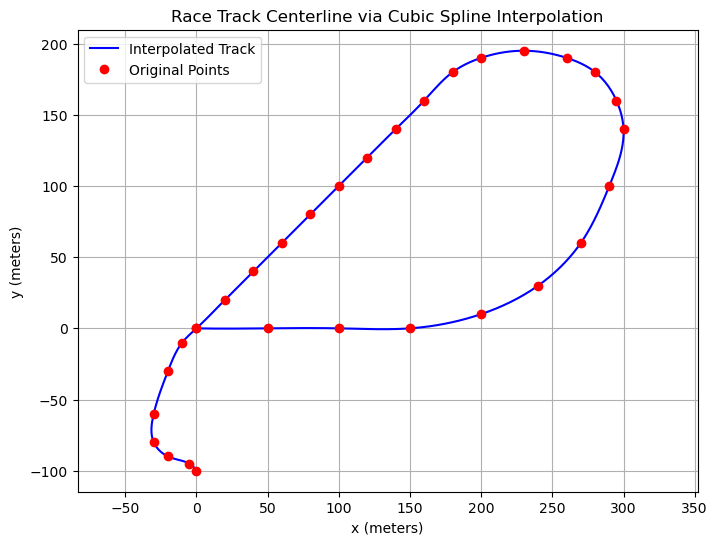

In [12]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

# 2. Reference path Optimization

According to Mathias, to simplify the problem, we can find an optimal path using MPC by setting the vehicle's velocity to be 1. The objective is then to maximize the vehicle's progress relative to the reference curve and to minimize the total curvature of the path. The curvature of the path is considered as a control variable and it is related to vehicle's tire model.

Inspired by Model Predictive Control (MPC), we first solve an optimization problem over a fixed prediction horizon. From the resulting solution, we apply only the control corresponding to the first time step. Then, we update the initial condition using the end state of the previous solution and repeat the process.

## 2.1 Problem formulation

Using $(s, r)$ to represent the vehicle's position, where $s$ is the projection on the centre line and $r$ is the lateral distance relative to it. Let $\kappa(t)$ be the curvature of the path at time $t$, $T$ be the predictive time scale, $t_i$ be the initial time, $\psi(t)$ be the path angle at time $t$, and $\psi_{\text{ref}}(t)$ be the centre line's angle at the vehicle's position at time $t$.

---

**Side notes – coordinate transform:**

$$
\kappa_{\text{ref}}(s) = \frac{x'_{\text{ref}}(s) y''_{\text{ref}}(s) - y'_{\text{ref}}(s) x''_{\text{ref}}(s)}{(x'_{\text{ref}}(s)^2 + y'_{\text{ref}}(s)^2)^{3/2}}
$$

$$
x(t) = x_{\text{ref}}(S(t)) - r(t) \cdot \sin(\psi_{\text{ref}}(S(t)))
$$

$$
y(t) = y_{\text{ref}}(S(t)) + r(t) \cdot \cos(\psi_{\text{ref}}(S(t)))
$$

---

According to Mathias, one possible formulation of this problem is the following:

### Objective

Minimize the objective function:

$$
-a_1 s(t_i + T) + a_2 \int_{t_i}^{t_i+T} \kappa(t)^2 \, dt
$$

### Subject to:

- **System dynamics:**


$$
\begin{cases}
\dot{s}(t) = \frac{\cos\big(\psi(t) - \psi_{\text{ref}}(t)\big)}{1 - r(t)\kappa_{\text{ref}}(s(t))}\\
\dot{r}(t) = \sin\big(\psi(t) - \psi_{\text{ref}}(t)\big)\\
\dot{\psi}(t) = \kappa(t)\\
\dot{\psi}_{\text{ref}}(t) = \kappa_{\text{ref}}(s(t)) \cdot \dot{s}(t)
\end{cases}
$$

- **Initial conditions:**

$$
\big(s(t_i),\, r(t_i),\, \psi(t_i),\, \psi_{\text{ref}}(t_i)\big) = \big(s_i,\, r_i,\, \psi_i,\, \psi_{\text{ref},i}\big)
$$

- **State constraints:**

$$
r(t) \in [r_{\min},\, r_{\max}]
$$

- **Control constraints:**

$$
\kappa(t) \in [\kappa_{\min},\, \kappa_{\max}]
$$


## 2.2 Problem discretization

For simplicity, $s(t_i)$ is written as $s_i$ and likewise. $h$ is the step size for discretizing time between $t_i$ and $t_i + T$. The number of discretization steps is $N - i + 1$. The trapezoidal rule is used for numerical integration, and the Euler method is used for the numerical solution of ODEs.


### **Objective:**

$$
-a_1 S_N + a_2 \sum_{n=1}^{N} \frac{h}{2} (\kappa_n + \kappa_{n-1})
$$


### **Subject to:**
- **System dynamics:**

For $j = i, \ldots, N-1$:

$$
\begin{cases}
S_{j+1} = S_j + h \cdot \dfrac{\cos(\psi_j - \psi_{\text{ref}, j})}{1 - r_j \kappa_{\text{ref}}(s_j)} \\
r_{j+1} = r_j + h \cdot \sin(\psi_j - \psi_{\text{ref}, j}) \\
\psi_{j+1} = \psi_j + h \kappa_j \\
\psi_{\text{ref}, j+1} = \psi_{\text{ref}, j} + h \cdot \kappa_{\text{ref}}(s_j) \cdot \dfrac{\cos(\psi_j - \psi_{\text{ref}, j})}{1 - r_j \kappa_{\text{ref}}(s_j)}
\end{cases}
$$


- **Initial Conditions:**

$$
(s_i, r_i, \psi_i, \psi_{\text{ref}, i})
$$


- **State Constraints:**

$$
r_j \in [r_{\min}, r_{\max}] \quad \text{for } j = i, \ldots, N
$$


- **Control Constraints:**

$$
\kappa_j \in [\kappa_{\min}, \kappa_{\max}] \quad \text{for } j = i, \ldots, N
$$


## 2.3 Solution

Using the idea from MPC. First solve a 

## 2.4 Python implementation


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13587
Number of nonzeros in inequality constraint Jacobian.:     3198
Number of nonzeros in Lagrangian Hessian.............:     7990

Total number of variables............................:     3999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3200
Total number of inequality c

  82 -1.7150417e+00 1.10e-02 1.76e-02  -5.7 1.16e+00  -3.8 5.40e-01 2.20e-01h  1
  83 -1.7196005e+00 6.62e-03 6.06e-03  -5.7 4.47e-01  -3.4 1.00e+00 5.35e-01h  1
  84 -1.7234462e+00 6.75e-03 1.51e-02  -5.7 1.27e+00  -3.8 4.58e-01 1.60e-01h  1
  85 -1.7260938e+00 5.00e-03 9.14e-03  -5.7 4.98e-01  -3.4 1.00e+00 2.91e-01h  1
  86 -1.7303888e+00 5.95e-03 3.29e-02  -5.7 1.38e+00  -3.9 1.00e+00 1.63e-01h  1
  87 -1.7389103e+00 1.24e-02 2.10e-03  -5.7 5.21e-01  -3.5 1.00e+00 8.48e-01h  1
  88 -1.7412501e+00 1.23e-02 4.05e-02  -5.7 1.58e+00  -3.9 1.00e+00 7.68e-02h  1
  89 -1.7436014e+00 9.88e-03 1.32e-02  -5.7 5.39e-01  -3.5 8.93e-01 2.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.7529336e+00 2.41e-02 3.37e-02  -5.7 1.65e+00  -4.0 9.30e-01 2.92e-01h  1
  91 -1.7581834e+00 1.56e-02 1.16e-02  -5.7 6.49e-01  -3.6 1.00e+00 4.14e-01h  1
  92 -1.7637837e+00 1.78e-02 5.22e-02  -5.7 1.94e+00  -4.0 1.00e+00 1.46e-01h  1
  93 -1.7701316e+00 1.26e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -2.1181505e+00 8.36e-03 2.68e-02  -5.7 1.14e+00  -4.5 1.00e+00 3.44e-01f  1
 181 -2.1203846e+00 5.81e-03 5.26e-03  -5.7 4.01e-01  -4.1 1.00e+00 6.27e-01h  1
 182 -2.1213435e+00 8.30e-03 5.77e-03  -5.7 3.41e+00  -4.5 1.08e-01 8.42e-02h  1
 183 -2.1234766e+00 4.69e-03 4.32e-03  -5.7 4.48e-01  -4.1 7.01e-01 5.35e-01h  1
 184 -2.1249467e+00 5.24e-04 3.52e-05  -5.7 1.72e-01  -3.7 1.00e+00 1.00e+00f  1
 185 -2.1279089e+00 4.99e-03 1.41e-04  -5.7 4.98e-01  -4.2 6.85e-01 6.76e-01h  1
 186 -2.1294309e+00 1.23e-03 1.13e-04  -5.7 2.09e-01  -3.7 1.00e+00 1.00e+00f  1
 187 -2.1318883e+00 4.47e-03 8.54e-03  -5.7 5.41e-01  -4.2 1.00e+00 5.42e-01h  1
 188 -2.1335673e+00 5.40e-03 1.16e-02  -5.7 3.12e+00  -4.7 2.20e-01 1.29e-01h  1
 189 -2.1356832e+00 4.78e-03 1.02e-02  -5.7 5.67e-01  -4.3 1.00e+00 4.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -2.1388321e+00 1.03e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -2.2046361e+00 6.61e-05 2.42e-04  -8.6 9.74e-02  -5.2 1.39e-01 3.06e-01h  1
 281 -2.2046409e+00 1.02e-04 1.25e-03  -8.6 2.06e-01  -5.7 4.24e-01 1.47e-01f  1
 282 -2.2046419e+00 1.30e-05 4.46e-07  -8.6 1.09e-02  -4.4 1.00e+00 1.00e+00f  1
 283 -2.2046434e+00 2.17e-05 2.42e-04  -8.6 3.11e-02  -4.9 6.82e-01 3.28e-01h  1
 284 -2.2046450e+00 1.68e-05 5.26e-07  -8.6 1.19e-02  -4.4 1.00e+00 1.00e+00f  1
 285 -2.2046502e+00 1.65e-04 4.03e-04  -8.6 4.16e-02  -4.9 3.99e-01 1.00e+00h  1
 286 -2.2046502e+00 4.05e-05 3.33e-05  -8.6 1.23e-02  -4.5 1.00e+00 8.34e-01h  1
 287 -2.2046514e+00 5.02e-05 3.41e-04  -8.6 3.80e-02  -5.0 1.00e+00 3.92e-01f  1
 288 -2.2046513e+00 5.22e-05 2.78e-04  -8.6 7.96e-02  -5.4 1.92e-01 1.98e-01f  1
 289 -2.2046520e+00 1.00e-04 6.81e-04  -8.6 7.65e-02  -5.0 2.31e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -2.2046526e+00 9.57e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380 -2.2046949e+00 7.21e-04 7.69e-04  -8.6 1.59e+00  -5.1 8.54e-03 1.81e-02h  1
 381 -2.2046952e+00 6.91e-04 6.19e-04  -8.6 1.76e-01  -4.7 1.35e-02 4.68e-02f  1
 382 -2.2046958e+00 6.91e-04 1.98e-03  -8.6 1.13e+01  -5.1 9.99e-03 6.13e-04f  1
 383 -2.2046963e+00 6.63e-04 2.30e-03  -8.6 2.44e-01  -4.7 2.48e-01 4.98e-02f  1
 384 -2.2046960e+00 6.49e-04 1.76e-03  -8.6 3.79e-02  -4.3 2.31e-01 2.08e-02h  4
 385 -2.2046958e+00 6.22e-04 9.68e-04  -8.6 4.35e-01  -4.8 2.26e-01 4.23e-02h  1
 386 -2.2046993e+00 6.77e-04 2.54e-04  -8.6 9.75e-01  -5.2 4.64e-03 3.61e-02f  1
 387 -2.2046993e+00 6.76e-04 4.94e-05  -8.6 6.59e-02  -4.8 2.93e-01 1.86e-03f  2
 388 -2.2046992e+00 6.67e-04 1.51e-04  -8.6 1.63e+00  -5.3 2.29e-02 1.47e-02h  3
 389 -2.2046911e+00 3.21e-04 3.63e-04  -8.6 1.32e-01  -4.9 2.41e-01 5.48e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 -2.2046956e+00 4.15e-04

 475 -2.2046937e+00 1.08e-04 1.02e-03  -8.6 3.51e-02  -4.4 5.98e-01 1.91e-02h  1
 476 -2.2046937e+00 1.16e-04 6.73e-04  -8.6 5.25e-01  -4.8 1.15e-01 2.79e-02f  3
 477 -2.2046939e+00 1.16e-04 4.13e-04  -8.6 1.26e+00  -5.3 1.95e-02 6.90e-03h  1
 478 -2.2046938e+00 1.15e-04 2.78e-04  -8.6 5.88e-02  -4.9 4.73e-01 9.38e-03f  5
 479 -2.2046944e+00 1.29e-04 3.66e-04  -8.6 1.08e+00  -5.4 1.16e-02 3.64e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -2.2046948e+00 1.28e-04 2.30e-03  -8.6 5.25e-01  -4.9 1.64e-01 7.36e-03h  1
 481 -2.2046950e+00 1.23e-04 2.33e-03  -8.6 1.13e-01  -4.5 7.02e-01 4.52e-02f  1
 482 -2.2046980e+00 1.51e-04 1.91e-03  -8.6 1.28e+00  -5.0 1.57e-02 4.90e-02f  1
 483 -2.2046977e+00 1.46e-04 1.61e-03  -8.6 7.67e-02  -4.6 1.47e-01 3.69e-02h  4
 484 -2.2046981e+00 1.49e-04 1.53e-03  -8.6 1.46e+00  -5.0 1.71e-02 1.32e-02h  1
 485 -2.2046981e+00 1.49e-04 1.67e-04  -8.6 8.65e-02  -4.6 6.26e-01 2.28e-03f  9
 486 -2.2046980e+00 1.46e-04

 569 -2.2046961e+00 9.19e-05 1.91e-03  -8.6 1.03e-01  -5.0 2.88e-01 1.37e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -2.2046974e+00 1.32e-04 1.68e-03  -8.6 1.13e-01  -4.5 6.76e-01 2.85e-01h  1
 571 -2.2046974e+00 1.31e-04 1.47e-03  -8.6 2.97e-01  -5.0 6.24e-02 1.49e-02f  2
 572 -2.2046968e+00 1.22e-04 1.45e-04  -8.6 9.68e-02  -4.6 8.18e-01 8.13e-02h  1
 573 -2.2046968e+00 1.22e-04 1.21e-03  -8.6 2.20e-01  -5.1 3.47e-01 3.91e-03f  9
 574 -2.2046892e+00 2.51e-05 2.96e-04  -8.6 2.69e-02  -4.6 4.13e-01 1.00e+00h  1
 575 -2.2046908e+00 2.69e-05 3.50e-03  -8.6 8.17e-01  -5.1 2.04e-01 1.72e-02h  1
 576 -2.2046908e+00 2.68e-05 1.06e-03  -8.6 8.47e-02  -4.7 5.56e-01 2.95e-03f  2
 577 -2.2046763e+00 2.49e-06 3.01e-03  -8.6 1.22e-01  -5.2 2.48e-01 1.00e+00H  1
 578 -2.2046770e+00 4.01e-06 3.51e-03  -8.6 1.66e-01  -4.7 5.77e-01 4.37e-02h  1
 579 -2.2046774e+00 6.37e-06 2.62e-03  -8.6 2.16e-01  -4.3 2.83e-01 5.89e-02f  2
iter    objective    inf_pr 

 665 -2.2047017e+00 2.27e-04 2.06e-03  -8.6 9.85e-02  -4.7 1.45e-01 6.38e-02h  2
 666 -2.2047017e+00 2.24e-04 1.20e-03  -8.6 5.22e-01  -5.2 1.20e-01 1.38e-02h  1
 667 -2.2047017e+00 2.23e-04 8.39e-04  -8.6 1.10e-01  -4.8 1.85e-01 4.33e-03h  6
 668 -2.2047018e+00 2.40e-04 7.22e-04  -8.6 8.15e-01  -5.2 2.94e-02 2.25e-02h  2
 669 -2.2047029e+00 2.38e-04 1.52e-03  -8.6 2.13e-01  -4.8 2.81e-01 8.83e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670 -2.2047031e+00 2.37e-04 1.26e-03  -8.6 1.46e+00  -5.3 2.02e-02 6.28e-03h  1
 671 -2.2047030e+00 2.36e-04 8.90e-04  -8.6 2.29e-01  -4.9 1.71e-01 2.59e-03f  7
 672 -2.2047037e+00 3.99e-04 1.15e-03  -8.6 8.33e+00  -5.3 4.15e-03 6.20e-03h  2
 673 -2.2047066e+00 4.92e-04 1.61e-03  -8.6 2.84e-01  -4.9 2.99e-01 1.84e-01h  1
 674 -2.2047063e+00 4.76e-04 1.61e-03  -8.6 3.13e-01  -5.4 2.57e-02 3.23e-02h  1
 675 -2.2047063e+00 4.75e-04 1.01e-03  -8.6 5.75e-02  -5.0 2.08e-01 2.42e-03f  8
 676 -2.2047042e+00 4.85e-04

 763 -2.2046899e+00 1.62e-05 2.58e-03  -8.6 1.03e-01  -4.5 1.00e+00 2.84e-02h  1
 764 -2.2046908e+00 1.86e-05 3.92e-03  -8.6 3.63e-01  -5.0 2.48e-01 2.12e-02f  2
 765 -2.2046922e+00 2.05e-05 2.12e-03  -8.6 9.69e-02  -4.6 1.00e+00 1.22e-01h  1
 766 -2.2046925e+00 2.04e-05 1.58e-03  -8.6 1.04e-01  -5.0 1.78e-01 7.42e-02h  1
 767 -2.2046957e+00 6.63e-05 1.13e-03  -8.6 1.06e-01  -4.6 3.07e-01 2.92e-01f  1
 768 -2.2046956e+00 6.45e-05 1.15e-03  -8.6 1.30e-01  -5.1 8.58e-03 3.05e-02f  3
 769 -2.2046950e+00 5.32e-05 6.99e-04  -8.6 5.70e-02  -4.7 3.47e-01 2.12e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 -2.2046950e+00 5.24e-05 6.89e-05  -8.6 9.05e-02  -5.1 3.06e-01 1.81e-02f  6
 771 -2.2046932e+00 3.49e-05 1.28e-04  -8.6 2.62e-02  -4.7 5.51e-01 7.22e-01h  1
 772 -2.2046933e+00 3.49e-05 5.06e-03  -8.6 9.25e-01  -5.2 2.22e-01 7.54e-04f  1
 773 -2.2046932e+00 3.49e-05 5.04e-03  -8.6 5.57e+01  -4.8 2.85e-04 4.47e-05f  4
 774 -2.2046935e+00 5.58e-05

 856 -2.2046971e+00 6.20e-05 2.40e-03  -8.6 1.42e-01  -4.6 8.14e-01 5.44e-02h  1
 857 -2.2046971e+00 6.19e-05 2.25e-03  -8.6 2.66e-01  -5.1 2.94e-02 1.60e-03f  2
 858 -2.2046970e+00 6.06e-05 1.74e-03  -8.6 7.00e-02  -4.7 1.82e-01 2.13e-02h  1
 859 -2.2046971e+00 5.87e-05 1.54e-03  -8.6 1.64e-01  -5.1 6.18e-02 3.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 -2.2046971e+00 5.84e-05 2.13e-03  -8.6 1.74e-01  -4.7 2.19e-01 5.06e-03f  1
 861 -2.2046976e+00 5.87e-05 2.70e-03  -8.6 8.01e+00  -5.2 8.51e-03 8.47e-04f  1
 862 -2.2046975e+00 5.81e-05 2.10e-03  -8.6 2.76e-01  -4.8 1.78e-01 1.17e-02h  5
 863 -2.2046977e+00 8.12e-05 1.67e-03  -8.6 2.66e+00  -5.3 2.16e-02 7.67e-03h  4
 864 -2.2046980e+00 8.00e-05 3.56e-03  -8.6 2.10e-01  -4.8 5.73e-01 1.90e-02h  1
 865 -2.2046999e+00 7.92e-05 3.52e-03  -8.6 1.17e+00  -5.3 1.47e-02 1.44e-02f  1
 866 -2.2046999e+00 7.87e-05 3.06e-03  -8.6 1.27e-01  -4.9 1.08e-01 6.38e-03f  4
 867 -2.2046999e+00 7.84e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 -2.2047504e+00 3.08e-03 2.01e-03  -8.6 1.19e+00  -5.2 2.15e-02 1.17e-02h  1
 951 -2.2047504e+00 3.08e-03 2.29e-03  -8.6 2.60e-01  -4.8 6.55e-02 9.77e-04f 11
 952 -2.2047928e+00 8.46e-03 6.53e-03  -8.6 1.58e+00  -5.3 9.78e-03 2.40e-01h  1
 953 -2.2047916e+00 8.27e-03 6.43e-03  -8.6 5.92e-01  -4.8 3.57e-02 2.30e-02h  1
 954 -2.2047916e+00 8.27e-03 2.81e-03  -8.6 3.41e-01  -4.4 1.00e+00 2.43e-04f  7
 955 -2.2047842e+00 7.46e-03 2.71e-03  -8.6 3.59e-01  -4.9 1.42e-01 1.09e-01h  1
 956 -2.2047809e+00 7.21e-03 3.10e-03  -8.6 1.41e-01  -4.5 6.54e-01 3.36e-02h  1
 957 -2.2047807e+00 7.17e-03 3.87e-03  -8.6 4.01e-01  -4.9 1.21e-01 4.74e-03h  7
 958 -2.2047722e+00 6.58e-03 3.50e-03  -8.6 6.44e-01  -4.5 1.01e-01 8.46e-02h  3
 959 -2.2047685e+00 5.86e-03 5.41e-03  -8.6 4.82e-01  -5.0 5.81e-01 2.45e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 -2.2047662e+00 5.69e-03

1048 -2.2047057e+00 2.18e-04 7.08e-04  -8.6 9.89e-02  -5.0 4.68e-01 1.92e-01h  1
1049 -2.2047052e+00 2.08e-04 6.11e-04  -8.6 3.35e-02  -4.6 6.43e-01 4.60e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 -2.2047029e+00 1.78e-04 3.59e-04  -8.6 1.28e-01  -5.1 2.20e-01 2.62e-01h  1
1051 -2.2047031e+00 1.74e-04 1.67e-04  -8.6 1.84e-01  -4.6 1.27e-01 2.25e-02h  1
1052 -2.2047051e+00 1.84e-04 9.18e-04  -8.6 2.03e+00  -5.1 3.78e-02 1.40e-02f  1
1053 -2.2047055e+00 1.78e-04 1.48e-03  -8.6 1.62e-01  -4.7 2.54e-01 5.20e-02h  1
1054 -2.2047055e+00 1.78e-04 8.90e-04  -8.6 1.82e-01  -5.2 1.21e-01 2.22e-03f  2
1055 -2.2047054e+00 1.77e-04 4.44e-04  -8.6 1.84e+00  -4.7 5.94e-02 3.11e-03h  4
1056 -2.2047045e+00 1.74e-04 1.20e-04  -8.6 1.82e-01  -5.2 1.91e-01 1.27e-01h  2
1057 -2.2047045e+00 1.74e-04 1.22e-03  -8.6 2.12e-01  -4.8 2.33e-01 4.72e-03h  1
1058 -2.2047061e+00 1.87e-04 1.70e-03  -8.6 1.01e+01  -5.3 5.83e-03 2.15e-03f  2
1059 -2.2047083e+00 2.30e-04

1141 -2.2047036e+00 9.03e-05 1.25e-04  -8.6 1.86e-01  -5.1 1.44e-01 3.81e-03f  2
1142 -2.2047010e+00 6.94e-05 2.62e-04  -8.6 3.66e-02  -4.7 6.86e-01 2.76e-01h  1
1143 -2.2047010e+00 6.89e-05 5.63e-04  -8.6 1.34e-01  -5.2 1.11e-01 7.93e-03f  4
1144 -2.2046988e+00 4.97e-05 3.47e-04  -8.6 3.39e-02  -4.8 2.65e-01 3.45e-01h  2
1145 -2.2046993e+00 5.07e-05 5.96e-04  -8.6 1.22e+00  -5.2 3.53e-02 3.95e-03h  1
1146 -2.2046994e+00 5.04e-05 1.13e-03  -8.6 1.94e-01  -4.8 1.37e-01 5.64e-03f  1
1147 -2.2046998e+00 5.10e-05 1.80e-03  -8.6 3.93e+00  -5.3 1.08e-02 1.01e-03f  1
1148 -2.2046997e+00 5.06e-05 6.01e-04  -8.6 6.41e-02  -4.9 4.02e-01 9.78e-03f  4
1149 -2.2046998e+00 5.15e-05 1.14e-04  -8.6 3.76e-01  -5.3 7.41e-02 2.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150 -2.2047008e+00 5.21e-05 6.05e-05  -8.6 2.32e-01  -4.9 4.01e-02 4.90e-02f  1
1151 -2.2047008e+00 5.21e-05 6.74e-04  -8.6 1.13e+00  -5.4 3.01e-02 3.77e-04f  2
1152 -2.2047001e+00 4.72e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240 -2.2047017e+00 5.06e-05 1.17e-04  -8.6 5.93e-01  -5.4 3.95e-02 2.25e-03f  1
1241 -2.2047016e+00 5.03e-05 7.70e-04  -8.6 6.98e-02  -5.0 4.21e-01 6.46e-03f  4
1242 -2.2047018e+00 5.29e-05 6.94e-04  -8.6 1.03e+00  -5.5 8.10e-03 1.09e-02h  2
1243 -2.2047018e+00 5.29e-05 4.18e-04  -8.6 4.79e-01  -5.0 9.04e-02 6.27e-04h  1
1244 -2.2047023e+00 5.40e-05 1.07e-03  -8.6 1.18e-01  -4.6 3.72e-01 8.62e-02f  1
1245 -2.2047022e+00 5.38e-05 4.64e-04  -8.6 1.23e-01  -5.1 1.73e-01 4.45e-03f  2
1246 -2.2047024e+00 5.42e-05 4.25e-04  -8.6 1.31e+01  -5.6 7.72e-04 6.48e-04h  1
1247 -2.2047025e+00 5.42e-05 7.66e-04  -8.6 4.97e-01  -5.1 3.01e-02 4.75e-04f  1
1248 -2.2047028e+00 5.65e-05 7.32e-04  -8.6 4.65e-01  -4.7 1.63e-02 2.01e-02f  1
1249 -2.2047028e+00 6.42e-05 6.46e-04  -8.6 6.78e-01  -5.2 2.82e-02 2.08e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250 -2.2047033e+00 6.55e-05

1338 -2.2047079e+00 1.01e-04 5.46e-04  -8.6 1.32e-01  -5.2 9.82e-02 6.28e-02h  3
1339 -2.2047080e+00 9.96e-05 2.12e-04  -8.6 1.88e-01  -4.8 1.65e-01 1.73e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 -2.2047094e+00 1.06e-04 1.81e-04  -8.6 6.85e-01  -5.3 1.91e-02 2.08e-02f  1
1341 -2.2047094e+00 1.06e-04 7.88e-05  -8.6 3.56e-02  -4.8 2.56e-01 1.62e-03f  7
1342 -2.2047095e+00 1.18e-04 1.42e-04  -8.6 5.06e+00  -5.3 4.15e-03 2.97e-03h  2
1343 -2.2047077e+00 1.05e-04 2.23e-04  -8.6 5.48e-02  -4.9 2.07e-01 1.23e-01h  2
1344 -2.2047076e+00 1.04e-04 8.96e-04  -8.6 2.80e-01  -5.4 1.22e-01 1.75e-02h  3
1345 -2.2047081e+00 1.04e-04 1.63e-04  -8.6 3.04e-01  -4.9 1.12e-01 2.36e-02h  2
1346 -2.2047081e+00 1.05e-04 2.51e-04  -8.6 1.09e+00  -5.4 7.85e-03 4.44e-03h  1
1347 -2.2047091e+00 1.10e-04 5.04e-04  -8.6 3.54e-01  -5.0 4.91e-03 3.58e-02f  1
1348 -2.2047091e+00 1.11e-04 3.77e-04  -8.6 8.24e-01  -5.5 3.34e-04 6.78e-03f  1
1349 -2.2047091e+00 1.10e-04

1436 -2.2047014e+00 7.88e-05 1.89e-03  -8.6 4.28e-01  -5.0 1.04e-01 1.67e-03h  1
1437 -2.2047021e+00 8.27e-05 1.76e-03  -8.6 1.24e-01  -4.6 3.50e-01 1.46e-01f  1
1438 -2.2047021e+00 8.24e-05 1.12e-03  -8.6 1.27e-01  -5.1 1.62e-01 3.43e-03f  5
1439 -2.2046992e+00 5.74e-05 9.05e-05  -8.6 3.58e-02  -4.6 7.42e-01 3.72e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440 -2.2046992e+00 5.67e-05 2.15e-04  -8.6 9.73e-02  -5.1 1.37e-01 1.13e-02f  4
1441 -2.2046951e+00 3.53e-05 1.54e-04  -8.6 2.97e-02  -4.7 5.97e-01 9.27e-01h  1
1442 -2.2046954e+00 3.55e-05 4.23e-03  -8.6 1.21e+00  -5.2 1.42e-01 2.53e-03f  1
1443 -2.2046961e+00 3.66e-05 4.05e-03  -8.6 1.97e-01  -4.7 4.11e-01 3.92e-02f  1
1444 -2.2046995e+00 7.17e-05 3.71e-03  -8.6 7.85e-01  -5.2 2.92e-02 4.14e-02f  1
1445 -2.2046995e+00 7.14e-05 2.13e-03  -8.6 4.54e-02  -4.8 3.53e-01 4.74e-03f  7
1446 -2.2046996e+00 8.25e-05 2.15e-03  -8.6 3.73e-01  -5.3 3.64e-02 5.18e-02h  1
1447 -2.2046995e+00 8.20e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530 -2.2046989e+00 3.53e-05 8.36e-05  -8.6 6.07e-02  -4.7 3.99e-01 7.37e-03f  5
1531 -2.2046989e+00 3.68e-05 1.25e-04  -8.6 1.82e-01  -5.2 1.25e-02 4.70e-02h  3
1532 -2.2046991e+00 3.68e-05 2.95e-03  -8.6 2.31e-01  -4.8 5.17e-01 1.12e-02h  1
1533 -2.2046992e+00 3.68e-05 3.41e-03  -8.6 9.73e-01  -5.2 2.32e-02 7.84e-04f  1
1534 -2.2047008e+00 4.87e-05 3.24e-03  -8.6 1.94e-01  -4.8 2.52e-01 1.05e-01F  1
1535 -2.2047008e+00 4.83e-05 2.35e-03  -8.6 1.91e-01  -5.3 1.26e-01 8.90e-03f  2
1536 -2.2047004e+00 4.55e-05 1.21e-03  -8.6 3.82e-02  -4.9 3.73e-01 6.47e-02h  1
1537 -2.2047004e+00 4.51e-05 1.31e-03  -8.6 2.43e-01  -5.3 8.18e-03 2.69e-02f  3
1538 -2.2046998e+00 4.19e-05 5.17e-04  -8.6 5.37e-02  -4.9 3.63e-01 1.20e-01h  3
1539 -2.2047006e+00 4.32e-05 9.66e-04  -8.6 2.04e+00  -5.4 1.29e-02 3.59e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540 -2.2047006e+00 4.29e-05

1626 -2.2046942e+00 2.41e-05 3.95e-03  -8.6 4.88e+00  -5.4 6.02e-03 4.13e-03f  2
1627 -2.2046945e+00 2.29e-05 2.95e-03  -8.6 6.78e-02  -4.9 2.39e-01 1.87e-01h  1
1628 -2.2046955e+00 2.60e-05 2.78e-03  -8.6 2.09e+00  -5.4 7.38e-04 3.96e-03f  1
1629 -2.2046963e+00 3.04e-05 2.63e-03  -8.6 6.10e-01  -5.0 2.19e-03 1.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630 -2.2046963e+00 2.98e-05 1.72e-03  -8.6 2.99e-02  -4.5 2.97e-01 2.04e-02f  5
1631 -2.2046964e+00 2.93e-05 1.31e-03  -8.6 4.14e-01  -5.0 1.06e-01 3.62e-02h  1
1632 -2.2046966e+00 3.34e-05 9.22e-04  -8.6 4.26e+00  -5.5 5.89e-03 2.23e-03f  3
1633 -2.2046969e+00 3.36e-05 1.75e-03  -8.6 5.03e-01  -5.1 7.99e-02 5.99e-03h  3
1634 -2.2046970e+00 3.36e-05 1.75e-03  -8.6 8.43e-01  -4.7 5.05e-03 2.13e-03h  4
1635 -2.2046972e+00 3.37e-05 2.08e-03  -8.6 6.27e-01  -5.1 2.84e-02 3.07e-03h  4
1636 -2.2046976e+00 3.39e-05 2.16e-03  -8.6 1.71e-01  -4.7 1.06e-01 2.73e-02h  3
1637 -2.2046976e+00 3.41e-05

1724 -2.2047010e+00 7.70e-05 5.14e-04  -8.6 1.05e-01  -5.1 1.32e-01 8.15e-03f  6
1725 -2.2046951e+00 5.41e-05 1.40e-04  -8.6 3.59e-02  -4.7 6.56e-01 1.00e+00h  1
1726 -2.2046955e+00 5.44e-05 4.91e-03  -8.6 4.47e+00  -5.2 4.48e-02 7.61e-04h  1
1727 -2.2046967e+00 5.68e-05 4.94e-03  -8.6 2.49e-01  -4.8 6.27e-01 5.23e-02f  1
1728 -2.2046978e+00 5.88e-05 5.00e-03  -8.6 9.50e-01  -5.2 1.87e-02 1.14e-02h  3
1729 -2.2046992e+00 6.20e-05 4.64e-03  -8.6 2.13e-01  -4.8 1.44e-01 6.99e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -2.2046993e+00 6.11e-05 3.57e-03  -8.6 3.38e-01  -5.3 1.12e-01 1.61e-02h  1
1731 -2.2046993e+00 6.07e-05 2.50e-03  -8.6 8.02e-02  -4.9 2.25e-01 6.49e-03f  6
1732 -2.2046994e+00 6.31e-05 2.30e-03  -8.6 2.21e+00  -5.4 8.36e-03 3.81e-03h  2
1733 -2.2047008e+00 7.02e-05 2.15e-03  -8.6 3.80e-01  -4.9 3.02e-02 4.06e-02h  1
1734 -2.2047007e+00 6.98e-05 7.45e-04  -8.6 2.90e-02  -4.5 5.48e-01 5.77e-03f  7
1735 -2.2047002e+00 6.47e-05

1824 -2.2047109e+00 1.70e-04 2.53e-04  -8.6 4.95e-02  -5.0 8.37e-02 2.18e-03f  9
1825 -2.2047110e+00 1.92e-04 9.36e-05  -8.6 1.14e+00  -5.5 1.05e-02 2.28e-02h  1
1826 -2.2047128e+00 2.13e-04 5.05e-04  -8.6 3.23e-01  -5.0 7.81e-03 8.39e-02f  1
1827 -2.2047127e+00 2.13e-04 4.96e-04  -8.6 5.28e-01  -5.5 2.36e-03 3.10e-03f  3
1828 -2.2047122e+00 2.06e-04 6.43e-04  -8.6 1.43e-01  -5.1 9.58e-02 3.15e-02h  1
1829 -2.2047122e+00 2.06e-04 5.14e-04  -8.6 2.43e-02  -4.7 4.69e-01 1.84e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830 -2.2047114e+00 1.96e-04 5.36e-04  -8.6 1.11e-01  -5.1 7.78e-02 5.37e-02h  4
1831 -2.2047075e+00 1.51e-04 5.11e-04  -8.6 3.56e-02  -4.7 6.45e-01 2.38e-01h  3
1832 -2.2047066e+00 1.43e-04 3.40e-04  -8.6 1.79e-01  -5.2 6.88e-02 1.01e-01h  3
1833 -2.2047067e+00 1.42e-04 2.00e-03  -8.6 2.71e-01  -4.8 3.38e-01 6.88e-03h  1
1834 -2.2047079e+00 1.45e-04 2.47e-03  -8.6 1.05e+00  -5.3 3.18e-02 1.05e-02f  2
1835 -2.2047088e+00 1.42e-04

1923 -2.2047026e+00 7.00e-05 8.05e-05  -8.6 1.07e+00  -5.3 1.54e-02 3.77e-03h  1
1924 -2.2047026e+00 6.96e-05 1.07e-04  -8.6 6.37e-02  -4.8 1.43e-01 5.22e-03f  7
1925 -2.2047025e+00 6.85e-05 3.17e-04  -8.6 1.96e-01  -5.3 6.98e-02 2.36e-02h  1
1926 -2.2047027e+00 6.80e-05 6.32e-05  -8.6 2.26e-01  -4.9 7.58e-02 1.13e-02f  1
1927 -2.2047027e+00 6.71e-05 3.46e-04  -8.6 2.48e-01  -5.4 8.37e-02 1.60e-02f  2
1928 -2.2047028e+00 6.69e-05 1.11e-04  -8.6 2.74e-01  -4.9 4.12e-02 2.11e-03h  1
1929 -2.2047043e+00 6.73e-05 1.04e-04  -8.6 1.51e+00  -5.4 1.39e-02 9.14e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930 -2.2047043e+00 6.71e-05 4.60e-04  -8.6 7.76e-02  -5.0 3.29e-01 2.67e-03f  4
1931 -2.2047043e+00 6.69e-05 5.75e-04  -8.6 4.96e-01  -5.5 2.12e-02 1.06e-02h  2
1932 -2.2047035e+00 6.09e-05 5.34e-04  -8.6 6.20e-02  -5.0 1.12e-01 9.63e-02h  2
1933 -2.2046962e+00 5.91e-05 1.37e-04  -8.6 3.42e-02  -4.6 1.36e-01 8.83e-01h  1
1934 -2.2046977e+00 6.47e-05

2017 -2.2046995e+00 3.74e-05 2.23e-03  -8.6 4.78e-01  -5.0 1.24e-01 1.48e-02h  3
2018 -2.2047015e+00 4.65e-05 2.17e-03  -8.6 2.87e+00  -5.4 5.54e-03 6.21e-03h  1
2019 -2.2047015e+00 4.63e-05 1.60e-03  -8.6 6.57e-02  -5.0 1.63e-01 4.48e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020 -2.2047018e+00 5.87e-05 1.59e-03  -8.6 3.61e+00  -5.5 4.61e-03 4.62e-03h  1
2021 -2.2047018e+00 5.81e-05 1.57e-03  -8.6 3.25e-01  -5.1 1.75e-02 1.73e-02f  2
2022 -2.2047023e+00 5.89e-05 1.70e-03  -8.6 8.57e+01  -5.5 1.15e-04 4.99e-05h  1
2023 -2.2047022e+00 5.85e-05 6.11e-04  -8.6 9.53e-02  -5.1 2.76e-01 7.16e-03f  5
2024 -2.2047023e+00 5.80e-05 9.34e-04  -8.6 1.33e-01  -4.7 1.36e-01 9.92e-03h  1
2025 -2.2047023e+00 5.78e-05 6.00e-05  -8.6 1.32e-01  -5.2 2.20e-01 3.18e-03f  2
2026 -2.2047017e+00 5.31e-05 1.24e-04  -8.6 2.76e-02  -4.7 1.65e-01 8.38e-02h  4
2027 -2.2047018e+00 5.31e-05 4.51e-04  -8.6 7.95e-01  -5.2 2.42e-02 5.32e-04h  1
2028 -2.2047024e+00 5.21e-05

2114 -2.2047050e+00 1.62e-04 5.64e-04  -8.6 1.41e-01  -5.2 1.35e-01 8.01e-03h  1
2115 -2.2047050e+00 1.62e-04 5.85e-04  -8.6 2.66e-02  -4.8 2.57e-01 2.37e-03f  8
2116 -2.2047045e+00 1.63e-04 7.24e-04  -8.6 1.96e-01  -5.2 1.30e-01 8.33e-02h  2
2117 -2.2047049e+00 1.60e-04 1.52e-04  -8.6 2.27e-01  -4.8 1.12e-01 2.29e-02h  1
2118 -2.2047048e+00 1.59e-04 6.28e-04  -8.6 1.45e-01  -5.3 1.48e-01 5.57e-03f  4
2119 -2.2047009e+00 1.05e-04 2.98e-04  -8.6 4.66e-02  -4.9 3.37e-01 4.40e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120 -2.2047010e+00 1.05e-04 5.37e-04  -8.6 1.09e+01  -5.3 3.26e-03 1.07e-04h  1
2121 -2.2047014e+00 1.05e-04 2.36e-03  -8.6 3.09e-01  -4.9 2.77e-01 1.60e-02f  1
2122 -2.2047022e+00 1.17e-04 1.57e-03  -8.6 1.14e-01  -4.5 7.27e-01 2.91e-01f  1
2123 -2.2047019e+00 1.12e-04 6.95e-04  -8.6 5.72e-02  -5.0 3.20e-01 4.16e-02h  1
2124 -2.2047022e+00 1.36e-04 3.63e-04  -8.6 8.15e-01  -5.4 4.41e-02 2.82e-02f  1
2125 -2.2047047e+00 1.68e-04

2207 -2.2046975e+00 4.50e-05 2.14e-03  -8.6 1.23e-01  -4.4 6.79e-01 3.70e-02f  1
2208 -2.2046976e+00 4.49e-05 3.78e-03  -8.6 3.07e-01  -4.9 3.07e-01 3.37e-03f  1
2209 -2.2046984e+00 4.68e-05 4.30e-03  -8.6 2.31e+00  -5.4 1.36e-02 3.25e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 -2.2046989e+00 4.79e-05 4.61e-03  -8.6 5.45e-01  -4.9 1.29e-01 1.32e-02h  4
2211 -2.2047031e+00 9.19e-05 4.11e-03  -8.6 3.68e+00  -5.4 4.27e-03 1.02e-02h  1
2212 -2.2047029e+00 8.92e-05 2.77e-03  -8.6 2.10e-01  -5.0 2.83e-01 3.17e-02h  2
2213 -2.2047032e+00 9.70e-05 3.04e-03  -8.6 1.83e+00  -5.5 8.64e-04 7.76e-03h  1
2214 -2.2047032e+00 9.67e-05 1.29e-03  -8.6 8.01e-02  -5.0 3.53e-01 3.77e-03f  8
2215 -2.2047034e+00 9.99e-05 9.16e-04  -8.6 6.87e+00  -5.5 3.72e-03 1.41e-03h  3
2216 -2.2047031e+00 9.71e-05 2.12e-04  -8.6 1.11e-01  -5.1 3.40e-01 3.37e-02h  4
2217 -2.2047031e+00 9.62e-05 4.56e-04  -8.6 7.89e-02  -4.7 2.26e-01 9.79e-03h  3
2218 -2.2047027e+00 9.21e-05

2304 -2.2047058e+00 1.08e-04 3.94e-04  -8.6 9.30e-02  -4.6 4.19e-01 1.73e-01h  1
2305 -2.2047058e+00 1.07e-04 6.42e-04  -8.6 7.73e-02  -5.1 2.01e-01 2.18e-03f  6
2306 -2.2047056e+00 1.05e-04 6.15e-04  -8.6 2.76e-02  -4.7 4.27e-01 1.84e-02h  4
2307 -2.2047056e+00 1.05e-04 9.65e-04  -8.6 9.37e-02  -5.2 2.25e-01 9.79e-04h  8
2308 -2.2046975e+00 4.50e-05 2.26e-04  -8.6 3.15e-02  -4.7 7.67e-01 7.65e-01h  1
2309 -2.2046977e+00 5.84e-05 2.70e-04  -8.6 3.05e-01  -5.2 7.09e-02 6.27e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310 -2.2046984e+00 5.90e-05 1.31e-04  -8.6 3.59e-01  -4.8 4.06e-02 1.75e-02f  1
2311 -2.2046992e+00 6.03e-05 1.80e-03  -8.6 2.61e+00  -5.3 3.18e-02 2.53e-03f  1
2312 -2.2047009e+00 7.23e-05 2.04e-03  -8.6 2.23e-01  -4.8 1.82e-01 7.79e-02f  1
2313 -2.2047009e+00 7.23e-05 1.20e-03  -8.6 2.08e-01  -5.3 1.26e-01 1.15e-03f  2
2314 -2.2047009e+00 7.22e-05 1.21e-03  -8.6 3.46e+00  -4.9 6.91e-04 9.24e-04h  2
2315 -2.2047009e+00 7.29e-05

2398 -2.2047023e+00 6.76e-05 5.45e-04  -8.6 1.71e-01  -5.2 7.20e-02 2.65e-02h  4
2399 -2.2046893e+00 1.02e-06 4.67e-04  -8.6 4.70e-02  -4.8 2.11e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400 -2.2046905e+00 2.86e-06 2.60e-03  -8.6 1.04e+01  -5.3 9.46e-03 1.01e-03h  1
2401 -2.2046912e+00 3.78e-06 3.21e-03  -8.6 2.57e-01  -4.9 2.01e-01 2.19e-02f  1
2402 -2.2046936e+00 2.32e-05 1.51e-03  -8.6 8.62e-02  -4.4 1.00e+00 2.50e-01f  1
2403 -2.2046944e+00 2.53e-05 1.77e-03  -8.6 2.54e-01  -4.9 9.38e-02 2.78e-02h  3
2404 -2.2046965e+00 3.80e-05 1.82e-03  -8.6 2.95e+00  -5.4 7.03e-03 6.01e-03h  2
2405 -2.2046964e+00 3.57e-05 1.00e-03  -8.6 5.64e-02  -5.0 2.97e-01 8.29e-02h  2
2406 -2.2046966e+00 3.79e-05 6.21e-04  -8.6 1.54e+00  -5.4 1.44e-02 4.42e-03h  2
2407 -2.2046966e+00 3.75e-05 2.10e-04  -8.6 7.54e-02  -5.0 4.35e-01 1.20e-01h  1
2408 -2.2046977e+00 4.14e-05 2.27e-04  -8.6 3.94e+01  -5.5 7.08e-04 2.45e-04f  2
2409 -2.2046977e+00 4.01e-05

2491 -2.2046993e+00 3.37e-05 9.93e-04  -8.6 1.55e+00  -5.3 1.04e-02 2.80e-03f  1
2492 -2.2047009e+00 3.68e-05 6.43e-04  -8.6 2.18e-01  -4.9 1.05e-02 7.92e-02f  1
2493 -2.2047009e+00 3.66e-05 1.41e-04  -8.6 2.39e-02  -4.5 7.82e-01 5.37e-03f  6
2494 -2.2047006e+00 3.48e-05 1.99e-04  -8.6 7.87e-02  -5.0 1.15e-01 6.91e-02h  1
2495 -2.2047007e+00 3.50e-05 5.45e-04  -8.6 4.13e-01  -5.5 4.77e-02 1.17e-02f  3
2496 -2.2047003e+00 3.40e-05 5.62e-04  -8.6 8.23e-02  -5.0 1.28e-01 8.49e-02h  3
2497 -2.2047007e+00 3.37e-05 4.99e-04  -8.6 1.38e-01  -4.6 2.97e-01 3.61e-02h  1
2498 -2.2047007e+00 3.35e-05 4.65e-04  -8.6 1.29e-01  -5.1 2.29e-02 6.49e-03f  4
2499 -2.2047000e+00 2.95e-05 3.91e-05  -8.6 2.68e-02  -4.6 5.23e-01 1.40e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 -2.2047000e+00 2.90e-05 1.16e-04  -8.6 1.34e-01  -5.1 5.96e-02 2.61e-02f  4
2501 -2.2047007e+00 3.05e-05 6.79e-04  -8.6 1.60e-01  -4.7 2.44e-01 4.96e-02h  1
2502 -2.2047006e+00 3.02e-05

2587 -2.2047025e+00 4.04e-05 6.07e-05  -8.6 1.68e-01  -5.1 3.12e-02 9.25e-03f  2
2588 -2.2047023e+00 3.90e-05 8.04e-05  -8.6 3.37e-02  -4.7 1.54e-01 3.55e-02h  1
2589 -2.2047022e+00 3.87e-05 3.54e-04  -8.6 1.05e-01  -5.1 1.20e-01 7.70e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590 -2.2047028e+00 3.91e-05 2.05e-04  -8.6 1.51e-01  -4.7 1.86e-01 5.54e-02h  1
2591 -2.2047028e+00 3.89e-05 1.35e-04  -8.6 9.57e-02  -5.2 3.17e-02 4.02e-03f  6
2592 -2.2047018e+00 3.39e-05 1.23e-04  -8.6 3.57e-02  -4.8 1.40e-01 1.48e-01h  2
2593 -2.2047017e+00 3.38e-05 1.70e-04  -8.6 1.41e-01  -5.2 1.12e-01 3.28e-02h  2
2594 -2.2047024e+00 3.46e-05 3.90e-05  -8.6 2.00e-01  -4.8 7.58e-02 4.13e-02h  1
2595 -2.2047023e+00 3.43e-05 1.10e-04  -8.6 1.73e-01  -5.3 3.79e-02 8.98e-03f  3
2596 -2.2047022e+00 3.41e-05 1.90e-04  -8.6 2.09e-01  -4.9 5.11e-02 1.51e-02h  3
2597 -2.2047023e+00 3.39e-05 6.33e-04  -8.6 3.23e-01  -5.3 7.01e-02 8.69e-03h  3
2598 -2.2047014e+00 3.01e-05

2685 -2.2047006e+00 2.97e-05 2.47e-04  -8.6 1.20e-01  -4.9 1.88e-01 1.07e-02f  5
2686 -2.2047007e+00 3.04e-05 4.65e-04  -8.6 2.77e-01  -5.4 6.12e-02 2.58e-02h  3
2687 -2.2047015e+00 3.44e-05 4.57e-04  -8.6 2.99e-01  -4.9 1.56e-01 3.20e-02h  1
2688 -2.2047016e+00 3.46e-05 5.87e-04  -8.6 3.62e-01  -5.4 3.33e-03 1.88e-02f  1
2689 -2.2047017e+00 3.45e-05 6.21e-04  -8.6 3.23e-01  -5.0 9.08e-03 4.09e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690 -2.2047025e+00 3.48e-05 7.46e-04  -8.6 2.35e+00  -5.5 5.15e-03 2.82e-03f  2
2691 -2.2047024e+00 3.42e-05 4.33e-04  -8.6 8.07e-02  -5.0 1.50e-01 1.72e-02h  1
2692 -2.2047023e+00 3.41e-05 3.20e-04  -8.6 7.41e-02  -4.6 8.13e-02 5.36e-03f  6
2693 -2.2047022e+00 3.36e-05 1.19e-04  -8.6 1.22e-01  -5.1 1.77e-01 2.35e-02h  1
2694 -2.2047033e+00 3.48e-05 2.63e-04  -8.6 7.72e+00  -5.6 4.17e-04 1.24e-03f  1
2695 -2.2047033e+00 3.48e-05 2.19e-04  -8.6 1.78e+00  -5.1 3.77e-03 9.89e-04f  3
2696 -2.2047033e+00 3.47e-05

2779 -2.2046986e+00 3.14e-05 1.39e-04  -8.6 2.68e-02  -4.6 7.84e-01 8.49e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2780 -2.2046986e+00 3.08e-05 5.09e-04  -8.6 9.72e-02  -5.1 1.96e-01 2.34e-02f  5
2781 -2.2046987e+00 3.07e-05 3.44e-03  -8.6 1.79e-01  -4.6 7.91e-01 3.52e-03h  1
2782 -2.2046994e+00 3.20e-05 3.72e-03  -8.6 5.12e-01  -5.1 5.34e-02 1.24e-02f  2
2783 -2.2046991e+00 2.96e-05 1.98e-03  -8.6 2.94e-02  -4.7 4.24e-01 8.29e-02h  1
2784 -2.2046991e+00 3.00e-05 1.71e-03  -8.6 1.26e-01  -5.2 8.29e-02 4.72e-02f  3
2785 -2.2047001e+00 3.62e-05 2.08e-03  -8.6 1.72e-01  -4.7 2.79e-01 7.48e-02H  1
2786 -2.2047001e+00 3.59e-05 2.01e-03  -8.6 1.49e-01  -5.2 2.17e-02 1.61e-02f  2
2787 -2.2046996e+00 3.28e-05 1.34e-03  -8.6 4.23e-02  -4.8 2.62e-01 1.23e-01h  2
2788 -2.2046996e+00 3.28e-05 6.04e-04  -8.6 1.78e-01  -5.3 1.48e-01 2.20e-02h  3
2789 -2.2047003e+00 3.45e-05 9.82e-04  -8.6 2.20e-01  -4.8 1.19e-01 3.20e-02h  2
iter    objective    inf_pr 

2873 -2.2046975e+00 4.20e-05 1.16e-03  -8.6 9.22e-01  -5.2 6.91e-02 6.17e-03f  1
2874 -2.2046997e+00 6.62e-05 9.02e-04  -8.6 1.58e-01  -4.8 1.15e-01 1.48e-01f  1
2875 -2.2046997e+00 6.60e-05 7.69e-04  -8.6 2.34e-01  -5.2 2.77e-02 3.83e-03h  2
2876 -2.2046996e+00 6.41e-05 2.26e-04  -8.6 4.03e-02  -4.8 3.56e-01 2.93e-02h  1
2877 -2.2046996e+00 6.25e-05 9.25e-05  -8.6 1.68e-01  -5.3 6.13e-02 3.18e-02f  3
2878 -2.2046992e+00 6.05e-05 1.13e-04  -8.6 8.71e-02  -4.9 1.08e-01 1.07e-01h  3
2879 -2.2047009e+00 6.67e-05 2.76e-04  -8.6 1.42e+00  -5.3 1.60e-02 1.03e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880 -2.2047009e+00 6.64e-05 6.04e-04  -8.6 5.01e-02  -4.9 6.02e-01 4.36e-03f  5
2881 -2.2047010e+00 1.08e-04 1.15e-04  -8.6 3.19e-01  -5.4 2.44e-02 1.05e-01h  1
2882 -2.2047015e+00 1.07e-04 3.49e-04  -8.6 3.83e-01  -5.0 4.92e-02 1.46e-02f  1
2883 -2.2047040e+00 1.23e-04 9.88e-04  -8.6 2.81e+00  -5.4 1.73e-02 7.79e-03f  1
2884 -2.2047040e+00 1.22e-04

2968 -2.2047044e+00 6.57e-05 4.20e-03  -8.6 1.75e+00  -5.4 1.13e-02 4.66e-04f  1
2969 -2.2047055e+00 6.89e-05 4.26e-03  -8.6 2.66e-01  -4.9 1.70e-01 5.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970 -2.2047055e+00 6.86e-05 3.11e-03  -8.6 3.50e-01  -5.4 1.07e-01 4.01e-03f  2
2971 -2.2047051e+00 6.54e-05 2.46e-03  -8.6 5.72e-02  -5.0 1.61e-01 5.10e-02h  1
2972 -2.2047051e+00 6.84e-05 2.35e-03  -8.6 6.40e-01  -5.5 1.76e-02 1.37e-02f  3
2973 -2.2047059e+00 7.09e-05 2.75e-03  -8.6 3.87e-01  -5.0 8.60e-02 2.27e-02h  1
2974 -2.2047059e+00 7.00e-05 2.85e-03  -8.6 3.62e-01  -5.5 2.02e-03 1.43e-02f  2
2975 -2.2047060e+00 6.98e-05 2.87e-03  -8.6 3.77e-01  -5.1 9.85e-03 3.84e-03h  1
2976 -2.2047060e+00 6.96e-05 2.67e-03  -8.6 3.01e-02  -4.7 6.33e-02 3.09e-03f  7
2977 -2.2047056e+00 6.78e-05 2.73e-03  -8.6 1.11e-01  -5.1 1.57e-02 5.63e-02h  2
2978 -2.2047057e+00 6.69e-05 2.83e-03  -8.6 1.50e-01  -4.7 1.90e-01 2.21e-02h  1
2979 -2.2047069e+00 7.41e-05

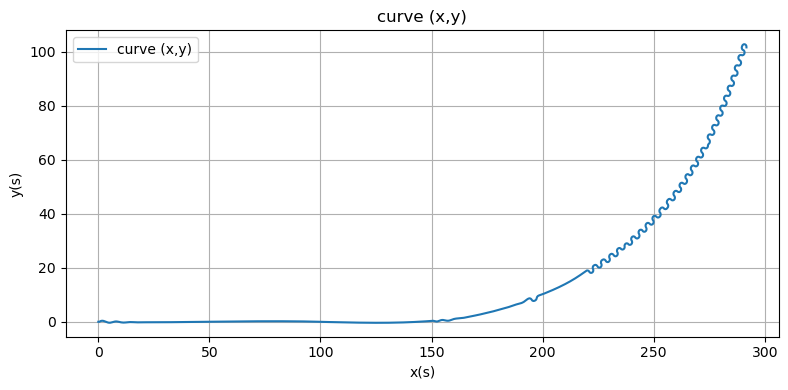

In [13]:
# parameters determination
T = 400     # predictive time
N = 800     # time steps
nx = 4     # dimension of state
nu = 1     # dimension of control
h = T/N    # time step size

# define the state and control constraint
kappa_min=-1
kappa_max=1
r_min=-1
r_max=1

# define all variables, X: states, U: control
X = ca.MX.sym("X", N * nx)
U = ca.MX.sym("U", (N - 1) * nu)

# x_list[i] = (s_i,r_i,phi_i,phi_{ref,i})
# u_list[i] = (Kappa_i)
x_list = [X[i*nx:(i+1)*nx] for i in range(N)]
u_list = [U[i*nu:(i+1)*nu] for i in range(N - 1)]

# define objective funtion
a1 = 6.5e-4
a2 = 1

obj = -a1*x_list[N-1][0]+a2*(h*sum(u[0] for u in u_list)-h*(u_list[0][0]+u_list[N-2][0])/2)

# define constraint list
g_list = []

# equality constraint
for i in range(N - 1):
    xi = x_list[i]
    ui = u_list[i]
    x_dot = ca.vertcat(
        ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0])),
        ca.sin(xi[2]-xi[3]),
        ui[0],
        kappa_ref(xi[0])*ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0]))
    )
    xi_next_pred = xi + h * x_dot
    g_list.append(x_list[i + 1] - xi_next_pred)
    
# initial condition
g_list.append(x_list[0] - [0,0,0,0])

# inequality constraint
for u in u_list:
    g_list.append(u[0] - kappa_max)     # u <= u_max => u - u_max <= 0
    g_list.append(-u[0] + kappa_min)    # -u <= -u_min => -u + u_min <= 0
for x in x_list:
    g_list.append(x[1] - r_max)
    g_list.append(-x[1] + r_min)

# concat all constraints
g = ca.vertcat(*g_list)

# concat all variables
Z = ca.vertcat(X, U)

# define the NLP problem
nlp = {'x': Z, 'f': obj, 'g': g}

# define the solver
solver = ca.nlpsol('solver', 'ipopt', nlp)

# initial guess
z0 = np.zeros(Z.shape[0])

# upper & lower bounds for constraints
n_eq = 4*N -4 + 4     # dynamical equation + initial condition
n_ineq = 2 * (N - 1) +2*N # upper and lower bounds for inequality constraint

lbg = [0] * n_eq + [-ca.inf] * n_ineq
ubg = [0] * n_eq + [0] * n_ineq

# solving
sol = solver(x0=z0, lbg=lbg, ubg=ubg)
z_opt = sol['x'].full().flatten()

# unpack variables
x_opt = z_opt[:nx*N].reshape((N, nx))
u_opt = z_opt[nx*N:].reshape((N - 1, nu))

print("if success:", solver.stats()['success'])
print("the first 5 states:", x_opt[:5])
print("the first 5 control:", u_opt[:5])

# Extract variables
s_vals = x_opt[:, 0]  # x[0], s
r_vals = x_opt[:, 1]  # x[1], r
phi_vals = x_opt[:,2] # x[2], phi
phi_ref_vals = x_opt[:,3] # x[3], phi_ref

# coordinate transform
x_vals=x_ref(s_vals).full().flatten()-r_vals*np.sin(phi_ref_vals)
y_vals=y_ref(s_vals).full().flatten()+r_vals*np.cos(phi_ref_vals)

# plot the curve (x(s),y(s))
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label='curve (x,y)')
plt.xlabel('x(s)')
plt.ylabel('y(s)')
plt.title('curve (x,y)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()